In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable

### Load Data


In [3]:
df = pd.read_csv('SBUX.csv', index_col = 'Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,79.847778,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,81.341644,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,81.765816,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,81.867264,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,81.267868,7296900


<Axes: title={'center': 'Starbucks Stock Volume'}, xlabel='Date'>

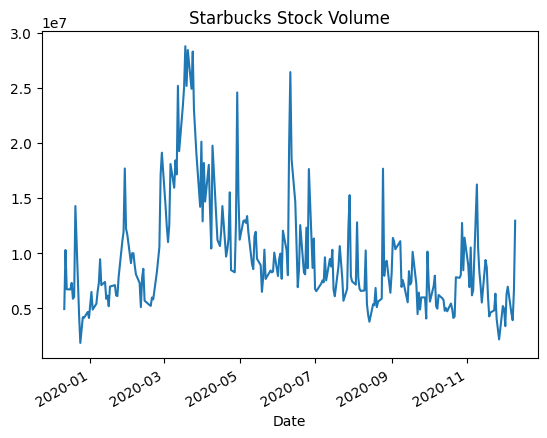

In [4]:
df['Volume'].plot(label='CLOSE', title='Starbucks Stock Volume')

### Data Pre-processing

In [5]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1:]

In [6]:
# use StandardScaler for the features
ss = StandardScaler()
X_ss = ss.fit_transform(X)

# use MinMaxScaler for the output values
mm = MinMaxScaler()
y_mm = mm.fit_transform(y)

In [7]:
# split training and testing datasets
# use the first 220 records for training, the rest for testing

X_train = X_ss[:220, :]
X_test = X_ss[220:, :]

y_train = y_mm[:220, :]
y_test = y_mm[220:, :]

In [8]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (220, 5) (220, 1)
Testing Shape (33, 5) (33, 1)


In [9]:
# convert datasets into tensors

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [10]:
# reshape
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([220, 1, 5]) torch.Size([220, 1])
Testing Shape torch.Size([33, 1, 5]) torch.Size([33, 1])


### LSTM Model

In [11]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [12]:
# define parameters

num_epochs = 1000
learning_rate = 0.005

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

In [13]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1])

In [14]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [15]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0

  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)

  loss.backward() #calculates the loss of the loss function

  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.05403
Epoch: 100, loss: 0.01686
Epoch: 200, loss: 0.01535
Epoch: 300, loss: 0.01099
Epoch: 400, loss: 0.01045
Epoch: 500, loss: 0.01032
Epoch: 600, loss: 0.01025
Epoch: 700, loss: 0.01019
Epoch: 800, loss: 0.01015
Epoch: 900, loss: 0.01010


### Prediction on Testing Dataset

In [16]:
test_predict = lstm1(X_test_tensors_final) #forward pass
data_predict = test_predict.data.numpy() #numpy conversion
data_predict = mm.inverse_transform(data_predict) #reverse transformation

<Axes: xlabel='Date'>

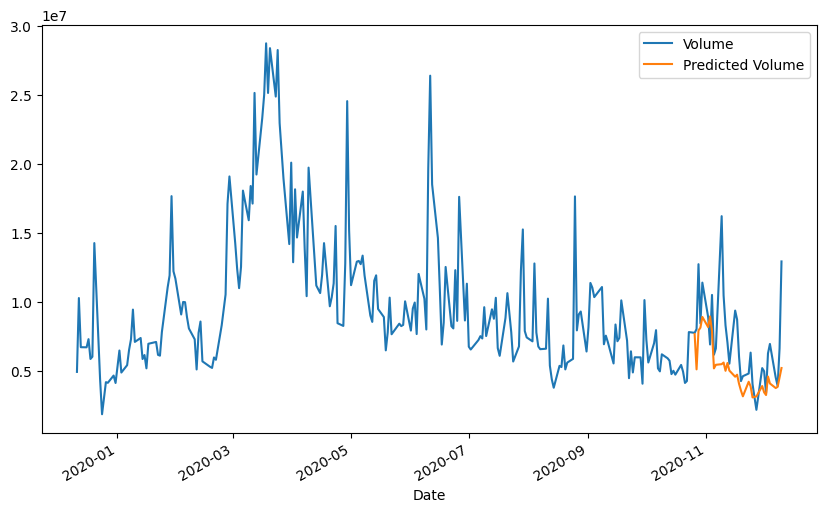

In [17]:
df['Predicted Volume'] = [None]*len(X_train) + [i[0] for i in data_predict]
df[['Volume','Predicted Volume']].plot(figsize=(10,6))

### Prediction on Whole Dataset

In [18]:
df = pd.read_csv('SBUX.csv', index_col = 'Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,79.847778,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,81.341644,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,81.765816,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,81.867264,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,81.267868,7296900


In [19]:
df_X_ss = ss.transform(df.iloc[:, :-1])
df_y_mm = mm.transform(df.iloc[:, -1:])

df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))

#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

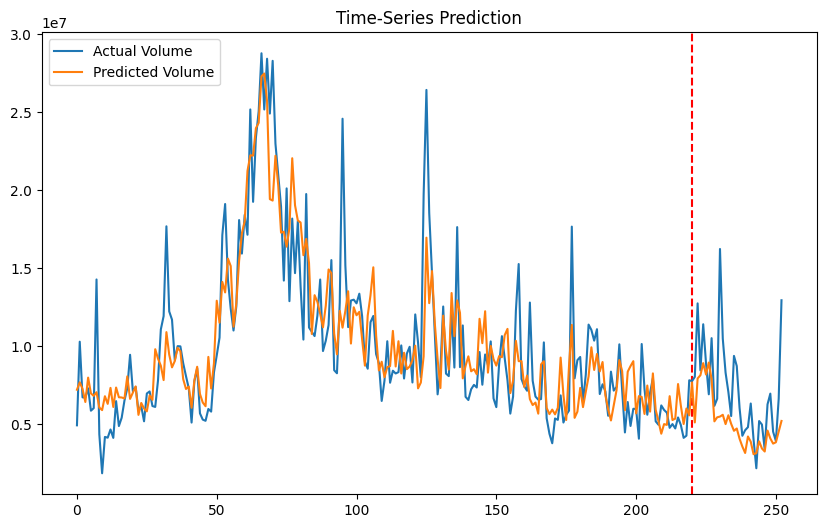

In [20]:
train_predict = lstm1(df_X_ss) #forward pass
data_predict = train_predict.data.numpy() #numpy conversion
data_actual = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
data_actual = mm.inverse_transform(data_actual)

plt.figure(figsize=(10,6))
plt.axvline(x=220, c='r', linestyle='--') #size of the training set
plt.plot(data_actual, label='Actual Volume')
plt.plot(data_predict, label='Predicted Volume')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()